### Installing Dependencies

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amrit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amrit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amrit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load Dataset

In [4]:
df = pd.read_csv('../data/SurgeDataset.csv')
df.head()

,worker_id,task_id,task_response_id,transaction_text,transaction_value,transaction_type,transaction_description,expense_intent
0,YYCA2DXN94NG,a9f6eed1-1c62-494e-8e06-787357e67e07,5f4d78f9-f7b0-4d93-8677-7226ad0147a8,8046 Debit Card Purchase Uber Help.Uber.Ca,4,Debit,This is a tip paid for an Uber ride.,Transportation / Taxis and ride shares
1,MFVVAY4H7Y4H,8c5c2797-544f-452e-b406-81784b36d741,d7577435-1ea4-48e4-ae7a-6f7047c2f8c0,UBER TRIP 8005928996 /CA US CARD PURCHASE,11.8,Debit,Uber trip from the hospital to my house.,Transportation / Public Transport
2,J6TM2D4MANTG,69332579-a566-4223-8f23-9fea43b44f87,35629ccf-9cb4-4945-9961-5fa176b0d2eb,DEBIT CARD PURCHASE XXXXX8046 LYFT *2 RIDES 04...,20.64,Debit,Rideshare charges for two rides.,"Rent & Utilities / Electricity, natural gas an..."
3,J6TM2D4MANTG,69332579-a566-4223-8f23-9fea43b44f87,fc10cc93-3953-4e6d-8859-9592b7d99bfc,DEBIT CARD PURCHASE XXXXX8046 LYFT *2 RIDES 04...,20.64,Debit,Rideshare charges for two rides.,Transportation / Taxis and ride shares
4,PC663CTNCDXX,cb24b81a-aa2b-4ca8-9fd0-95ccca8ce55d,74bef5cf-7d55-4af6-bc8d-fffe103cd393,LYFT 2 RIDES 05-26 Debit Card,93.45,Debit,This was the cost of taking two Lyft rides in ...,Transportation / Taxis and ride shares


### Data Cleaning

In [6]:
# Displaying the column names
print(df.columns)
desired = ["transaction_value", "transaction_description", "expense_intent"]
# Selecting only the desired columns
df_filtered = df[desired]

df_filtered.to_csv('../data/filteredExportAmt.csv', index=True)

Index(['worker_id', 'task_id', 'task_response_id', 'transaction_text',
       'transaction_value', 'transaction_type', 'transaction_description',
       'expense_intent'],
      dtype='object')


In [4]:
# Concatenating "transaction_description" with "transaction_value"
df_filtered['expense'] = df_filtered['transaction_description'] + ' Rs ' + df_filtered['transaction_value'].astype(str)

# Dropping the original columns
df_filtered.drop(columns=['transaction_value', 'transaction_description'], inplace=True)

df_filtered['expense_intent'] = df_filtered['expense_intent'].apply(lambda x: x.split('/')[0].strip())

C:\Users\amrit\AppData\Local\Temp\ipykernel_30604\2575348888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['expense'] = df_filtered['transaction_description'] + ' Rs ' + df_filtered['transaction_value'].astype(str)
C:\Users\amrit\AppData\Local\Temp\ipykernel_30604\2575348888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['transaction_value', 'transaction_description'], inplace=True)
C:\Users\amrit\AppData\Local\Temp\ipykernel_30604\2575348888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [5]:
display(df_filtered)

,expense_intent,expense
0,Transportation,This is a tip paid for an Uber ride. Rs 4
1,Transportation,Uber trip from the hospital to my house. Rs 11.8
2,Rent & Utilities,Rideshare charges for two rides. Rs 20.64
3,Transportation,Rideshare charges for two rides. Rs 20.64
4,Transportation,This was the cost of taking two Lyft rides in ...
...,...,...
517,Entertainment,This was for my Amazon Prime membership. Rs 6.59
518,Entertainment,I bought a CD. Rs 13.24
519,Entertainment,I paid for my Netflix subscription. Rs 16.79
520,Entertainment,A family visit to a children's place centre. R...


In [33]:
df_filtered.to_csv('../data/filteredExport.csv', index=True)

In [6]:
df_filtered["expense_intent"].value_counts()

expense_intent
Food & Drink               138
General Merchandise         58
Bank Transfers              54
Entertainment               51
Loans                       48
Rent & Utilities            40
Income                      32
Transportation              30
General Services            30
Medical                     20
Government + Non-Profit     16
Travel                       5
Name: count, dtype: int64

### Text Processing

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]  # Lemmatization
    tokens = [token for token in tokens if token not in stop_words]  # Removing stop words
    return ' '.join(tokens)

df['expense'] = df_filtered['expense'].apply(preprocess_text)

### Split Data into Train and Test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered['expense'], df_filtered['expense_intent'], test_size=0.2, random_state=42)

In [9]:
y_test

434             Bank Transfers
440              Entertainment
6               Transportation
184                      Loans
78              Transportation
                ...           
342               Food & Drink
412               Food & Drink
301               Food & Drink
428             Bank Transfers
153    Government + Non-Profit
Name: expense_intent, Length: 105, dtype: object

### Vectorize Text data

In [10]:
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [11]:
y_train

220                 Income
69          Transportation
374           Food & Drink
305    General Merchandise
173       General Services
              ...         
71        Rent & Utilities
106                  Loans
270    General Merchandise
435          Entertainment
102                  Loans
Name: expense_intent, Length: 417, dtype: object

In [12]:
# Vectorize text data
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train a Classifier

In [14]:
classifier = MultinomialNB()
classifier.fit(X_train_vectors, y_train)

MultinomialNB()

### Save the Model

In [15]:
import joblib
# Save the trained model to a file using joblib
joblib.dump(classifier, '../models/surge_exp_classifier.joblib')

['../models/surge_exp_classifier.joblib']

### Saving the Vectorizer

In [16]:
import joblib
# Save the vectorizer to a file using joblib
joblib.dump(vectorizer, '../models/surge_tfidf_vectorizer.joblib')

['../models/surge_tfidf_vectorizer.joblib']

### Loading the Model

In [17]:
import joblib
# Load the trained model from the file using joblib
classifier = joblib.load('../models/surge_exp_classifier.joblib')

### Evaluate the Classifier

In [18]:
predictions = classifier.predict(X_test_vectors)
print(classification_report(y_test, predictions))

                         precision    recall  f1-score   support

         Bank Transfers       0.67      0.73      0.70        11
          Entertainment       0.75      0.23      0.35        13
           Food & Drink       0.29      1.00      0.46        23
    General Merchandise       0.00      0.00      0.00         9
       General Services       0.00      0.00      0.00         3
Government + Non-Profit       0.00      0.00      0.00         3
                 Income       0.00      0.00      0.00         8
                  Loans       1.00      0.67      0.80         9
                Medical       0.00      0.00      0.00         2
       Rent & Utilities       1.00      0.36      0.53        14
         Transportation       0.00      0.00      0.00         8
                 Travel       0.00      0.00      0.00         2

               accuracy                           0.43       105
              macro avg       0.31      0.25      0.24       105
           weighted avg

E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(max_depth=30, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_vectors, y_train)

# Predict the labels for the test data
y_pred_rf = rf_classifier.predict(X_test_vectors)

# Calculate the accuracy of the classifier
# accuracy = accuracy_score(y_test, y_pred_rf)
print(classification_report(y_test, y_pred_rf))

                         precision    recall  f1-score   support

         Bank Transfers       0.62      0.73      0.67        11
          Entertainment       0.67      0.46      0.55        13
           Food & Drink       0.48      1.00      0.65        23
    General Merchandise       0.50      0.11      0.18         9
       General Services       0.00      0.00      0.00         3
Government + Non-Profit       0.00      0.00      0.00         3
                 Income       1.00      0.50      0.67         8
                  Loans       0.75      1.00      0.86         9
                Medical       0.00      0.00      0.00         2
       Rent & Utilities       1.00      0.79      0.88        14
         Transportation       0.75      0.38      0.50         8
                 Travel       0.00      0.00      0.00         2

               accuracy                           0.62       105
              macro avg       0.48      0.41      0.41       105
           weighted avg

E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Support Vector Machines

In [21]:
from sklearn import svm

clf = svm.SVC()

# Train the classifier on the training data
clf.fit(X_train_vectors, y_train)

# Predict the labels for the test data
y_pred_svc = clf.predict(X_test_vectors)

# Calculate the accuracy of the classifier

print(classification_report(y_test, y_pred_svc))

                         precision    recall  f1-score   support

         Bank Transfers       0.70      0.64      0.67        11
          Entertainment       1.00      0.31      0.47        13
           Food & Drink       0.34      1.00      0.51        23
    General Merchandise       1.00      0.11      0.20         9
       General Services       0.00      0.00      0.00         3
Government + Non-Profit       0.00      0.00      0.00         3
                 Income       1.00      0.12      0.22         8
                  Loans       1.00      1.00      1.00         9
                Medical       0.00      0.00      0.00         2
       Rent & Utilities       1.00      0.57      0.73        14
         Transportation       0.50      0.12      0.20         8
                 Travel       0.00      0.00      0.00         2

               accuracy                           0.51       105
              macro avg       0.54      0.32      0.33       105
           weighted avg

E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Programing\ML\ml-venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Accuracy

In [27]:
from sklearn.metrics import accuracy_score

y_test  # Actual labels
nb_predictions = classifier.predict(X_test_vectors)  # Predictions from MultinomialNB
rf_predictions = rf_classifier.predict(X_test_vectors)  # Predictions from Random Forest
svm_predictions = clf.predict(X_test_vectors)  # Predictions from SVM

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, nb_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# Print the accuracies
print("\033[1mAccuracy\033[0m ")
print("MultinomialNB: {:.2%}".format(nb_accuracy))
print("Random Forest: {:.2%}".format(rf_accuracy))
print("Support Vector Machines: {:.2%}".format(svm_accuracy))

Accuracy 
MultinomialNB: 42.86%
Random Forest: 61.90%
Support Vector Machines: 51.43%


### Visualising Accuracy

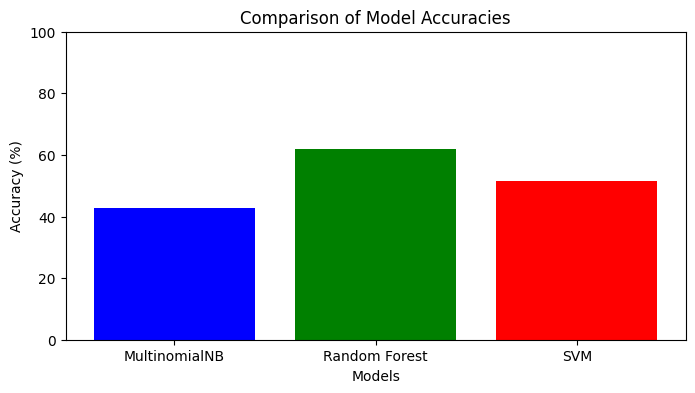

In [28]:
import matplotlib.pyplot as plt

# Accuracies from each model
accuracies = [42.86, 61.90, 51.43]
models = ['MultinomialNB', 'Random Forest', 'SVM']

# Create a bar plot
plt.figure(figsize=(8, 4))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 100])  # Set the limits for the Y-axis

# Show the plot
plt.show()

### User Input

In [29]:
def preprocess_input_text(text):
    # Preprocess the input text
    preprocessed_text = preprocess_text(text)
    # Vectorize the preprocessed text
    text_vector = vectorizer.transform([preprocessed_text])
    return text_vector

def classify_input(text):
    # Preprocess and vectorize the input text
    text_vector = preprocess_input_text(text)
    # Classify the input text 
    # MultinomialNB
    nv_predicted_label = classifier.predict(text_vector)
    # rf
    rf_predicted_label = rf_classifier.predict(text_vector)
    # svm
    svm_predicted_label = clf.predict(text_vector)
    return nv_predicted_label[0], rf_predicted_label[0], svm_predicted_label[0]

# Input text message
input_text = input("Enter your expense message: ")
# Classify the input text
nb, rf, svm = classify_input(input_text)

Enter your expense message:  I subscribed to netflix for 1999 Rs


### Display Labels

In [30]:
print("\033[1mPredicted Label\033[0m")
print("MultinomialNB: ", nb)
print("Random Forest: ", rf)
print("Support Vector Machines: ", svm)

Predicted Label
MultinomialNB:  Entertainment
Random Forest:  Food & Drink
Support Vector Machines:  Entertainment


### Tableau

In [42]:
from IPython.display import IFrame

# Replace 'your_dashboard_url' with the URL of your Tableau Public dashboard
dashboard_url = 'https://public.tableau.com/views/FDSExpensetracker/Dashboard1?:language=en-US&publish=yes&:sid=&:display_count=n&:origin=viz_share_link'

# Embed the dashboard URL as an iframe
IFrame(dashboard_url, width=800, height=600)
